In [1]:
from datasets import Dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, TrainingArguments, logging
from tqdm import tqdm
logging.set_verbosity_error()
from peft import LoraConfig, PeftConfig, PeftModel
from trl import SFTTrainer
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import numpy as np
import os
import sys
import gc
milestone_2_path = os.path.abspath("../milestone 2")
sys.path.append(milestone_2_path)

import import_preprocess
from importlib import reload
reload(import_preprocess)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int

2025-01-16 12:23:31.588756: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-16 12:23:31.588818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-16 12:23:31.606606: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 12:23:31.652651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 12:23:32.502998: W tensorflow/compiler/tf2

# Some initial testing with different Llama models

In [2]:
# # model_id = "meta-llama/Llama-3.2-3B"
# model_id = "meta-llama/Llama-3.2-3B-Instruct"
# tokenizer = AutoTokenizer.from_pretrained(model_id)
#
# # gptq_config = GPTQConfig(
# #     bits=bits,
# #     tokenizer=tokenizer,
# #     use_exllama=False,
# #     use_cuda_fp16=True,
# #     dataset="c4-new"
# # )
#
# model = AutoModelForCausalLM.from_pretrained(
#     model_id,
#     device_map="cuda:0"
# )
#
# model.config.use_cache = False
#
# pipe = pipeline(
#     "text-generation",
#     model=model,
#     tokenizer=tokenizer,
#     # torch_dtype=torch.float16,
#     # device="",
# )
# # quantized_model.save_pretrained(f"test-{model_name}-{bits}bit")

In [3]:
# tokenizer.pad_token_id = tokenizer.eos_token_id
# model.config.use_cache = False
#
# messages = [{"role": "user", "content": "Tell me something unexpected about austria"}]
#
# prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
# # outputs = pipe(prompt, max_new_tokens=120, do_sample=True, temperature=0.7)
# outputs = pipe(prompt, max_new_tokens=1000)#, temperature=1.0)
# print(outputs[0]["generated_text"])

# Load data

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset(n_samples=7000)

_, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
_, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
_, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
_, y_balanced, S_balanced, y_balanced_multi = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced, import_preprocess.S_train_balanced, import_preprocess.y_train_multi_balanced

print("Number of training samples:", len(y_train))
print("Number of validation samples:", len(y_val))
print("Number of test samples:", len(y_test))
print("Number of balanced samples:", len(y_balanced))

train_df = pd.DataFrame({"comment": S_train, "label": y_train, "multi_label": y_train_multi})
val_df = pd.DataFrame({"comment": S_val, "label": y_val, "multi_label": y_val_multi})
test_df = pd.DataFrame({"comment": S_test, "label": y_test, "multi_label": y_test_multi})
balanced_df = pd.DataFrame({"comment": S_balanced, "label": y_balanced, "multi_label": y_balanced_multi})

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 14000


In [3]:
def generate_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label: {entry["label"]}
""".strip()

def generate_test_prompt(entry):
    return f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: {entry["comment"]}
label:
""".strip()

train_df["text"] = train_df.apply(generate_prompt, axis=1)
val_df["text"] = val_df.apply(generate_prompt, axis=1)
balanced_df["text"] = balanced_df.apply(generate_prompt, axis=1)
test_df["text"] = test_df.apply(generate_test_prompt, axis=1)
train_df.label.value_counts()

label
not sexist    10602
sexist         3398
Name: count, dtype: int64

In [4]:
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)
balanced_data = Dataset.from_pandas(balanced_df)
test_data = Dataset.from_pandas(test_df)

# Evaluate model without fine-tuning

In [5]:
def clear_memory():
    try:
        global model
        global tokenizer
        del model, tokenizer
    except NameError:
        pass
    finally:
        gc.collect()
        torch.cuda.empty_cache()

In [8]:
clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)

model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
def predict(test_data, model, tokenizer, categories, temperature=0.01):
    y_pred = []
    categories = categories

    for i in tqdm(range(len(test_data))):
        prompt = test_data[i]["text"]

        pipe = pipeline(
            task="text-generation",
            model=model,
            tokenizer=tokenizer,
            max_new_tokens=2,
            temperature=temperature
        )
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("label:")[-1].strip()

        for category in categories:
            if category == answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")

    return y_pred

In [7]:
def evaluate(y_true, y_pred):
    labels = ["not sexist", "sexist", "none"]
    mapping = {label: idx for idx, label in enumerate(labels)}

    def map_func(x):
        return mapping.get(x, -1)

    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)

    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')

    unique_labels = set(y_true_mapped)

    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')

    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))), zero_division=0)
    print('\nClassification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [11]:
y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
evaluate(y_test, y_pred)

100%|██████████| 4000/4000 [03:11<00:00, 20.94it/s]

Accuracy: 0.571
Accuracy for label not sexist: 0.480
Accuracy for label sexist: 0.855

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.92      0.48      0.63      3030
      sexist       0.35      0.85      0.49       970
        none       0.00      0.00      0.00         0

    accuracy                           0.57      4000
   macro avg       0.42      0.44      0.37      4000
weighted avg       0.78      0.57      0.60      4000


Confusion Matrix:
[[1453 1555   22]
 [ 133  829    8]
 [   0    0    0]]


# Define functions for fine-tuning

In [8]:
def find_all_linear_names(model):
    cls = torch.nn.Linear
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [9]:
def fine_tune(model, tokenizer, train_dataset, eval_dataset, fine_tuned_dir, new_model_dir, epochs):
    modules = find_all_linear_names(model)

    peft_config = LoraConfig(
        lora_alpha=16,
        lora_dropout=0,
        r=64,
        bias="none",
        task_type="CAUSAL_LM",
        target_modules=modules,
    )

    training_arguments = TrainingArguments(
        output_dir=fine_tuned_dir,                    # directory to save and repository id
        num_train_epochs=epochs,                  # number of training epochs
        per_device_train_batch_size=1,            # batch size per device during training
        gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
        gradient_checkpointing=True,              # use gradient checkpointing to save memory
        optim="paged_adamw_32bit",
        logging_steps=1,
        learning_rate=2e-4,                       # learning rate, based on QLoRA paper
        weight_decay=0.001,
        fp16=True,
        bf16=False,
        max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
        max_steps=-1,
        warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
        group_by_length=False,
        lr_scheduler_type="cosine",               # use cosine learning rate scheduler
        evaluation_strategy="epoch",             # Evaluate at the end of every epoch
        report_to=["tensorboard"],                # Log metrics to TensorBoard
        save_strategy="epoch",                    # Save model at the end of every epoch
    )

    trainer = SFTTrainer(
        model=model,
        args=training_arguments,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        peft_config=peft_config,
        tokenizer=tokenizer,
    )

    trainer.train()

    trainer.save_model(fine_tuned_dir)
    tokenizer.save_pretrained(fine_tuned_dir)

    model = PeftModel.from_pretrained(model, fine_tuned_dir)
    model = model.merge_and_unload()

    model.save_pretrained(new_model_dir)
    tokenizer.save_pretrained(new_model_dir)

    del trainer

    return model, tokenizer

# Fine-tune model on train set

In [14]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
output_dir_base = "llama-3.2-fine-tuned-train"
new_model_dir_base = "Llama-3.2-3B-Instruct-Sexism-Classification-Train"

epochs = 5
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, train_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_125812/1456593974.py:35: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'loss': 34.2936, 'grad_norm': 6.121873378753662, 'learning_rate': 7.604562737642586e-07, 'epoch': 0.0005714285714285715}
{'loss': 31.8518, 'grad_norm': 6.1572699546813965, 'learning_rate': 1.5209125475285172e-06, 'epoch': 0.001142857142857143}
{'loss': 31.3012, 'grad_norm': 5.501338481903076, 'learning_rate': 2.281368821292776e-06, 'epoch': 0.0017142857142857142}
{'loss': 33.1582, 'grad_norm': 5.4560675621032715, 'learning_rate': 3.0418250950570345e-06, 'epoch': 0.002285714285714286}
{'loss': 32.4936, 'grad_norm': 5.463005542755127, 'learning_rate': 3.8022813688212926e-06, 'epoch': 0.002857142857142857}
{'loss': 31.2595, 'grad_norm': 5.612952709197998, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.0034285714285714284}
{'loss': 31.0172, 'grad_norm': 5.250010013580322, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004}
{'loss': 32.5899, 'grad_norm': 6.2719011306762695, 'learning_rate': 6.083650190114069e-06, 'epoch': 0.004571428571428572}
{'loss': 33.9541, 'grad_norm': 5.511097

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 04996b8c-8d0e-4eee-91f4-984437bacea2)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 14.9567, 'grad_norm': 2.03979229927063, 'learning_rate': 0.00018522966761235472, 'epoch': 1.0005714285714287}
{'loss': 14.3832, 'grad_norm': 2.0355513095855713, 'learning_rate': 0.0001852102999580612, 'epoch': 1.0011428571428571}
{'loss': 13.3768, 'grad_norm': 2.0213863849639893, 'learning_rate': 0.0001851909206280542, 'epoch': 1.0017142857142858}
{'loss': 13.5212, 'grad_norm': 1.8584526777267456, 'learning_rate': 0.00018517152962498908, 'epoch': 1.0022857142857142}
{'loss': 13.8551, 'grad_norm': 1.9313554763793945, 'learning_rate': 0.00018515212695152284, 'epoch': 1.002857142857143}
{'loss': 13.5005, 'grad_norm': 2.035161256790161, 'learning_rate': 0.00018513271261031406, 'epoch': 1.0034285714285713}
{'loss': 14.4132, 'grad_norm': 1.9953370094299316, 'learning_rate': 0.000185113286604023, 'epoch': 1.004}
{'loss': 15.616, 'grad_norm': 2.157604217529297, 'learning_rate': 0.0001850938489353114, 'epoch': 1.0045714285714287}
{'loss': 13.4786, 'grad_norm': 2.5143797397613525, 'lear

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: f5aae07f-880c-45a8-be03-53d60edad545)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 6.8287, 'grad_norm': 3.8440186977386475, 'learning_rate': 7.289559207374341e-05, 'epoch': 3.0005714285714284}
{'loss': 8.3401, 'grad_norm': 3.9765403270721436, 'learning_rate': 7.285996304643966e-05, 'epoch': 3.0011428571428573}
{'loss': 7.3541, 'grad_norm': 3.7812671661376953, 'learning_rate': 7.282433773792689e-05, 'epoch': 3.001714285714286}
{'loss': 5.9912, 'grad_norm': 3.7889418601989746, 'learning_rate': 7.27887161530866e-05, 'epoch': 3.0022857142857142}
{'loss': 8.4675, 'grad_norm': 4.0169172286987305, 'learning_rate': 7.275309829679972e-05, 'epoch': 3.0028571428571427}
{'loss': 8.161, 'grad_norm': 4.225139617919922, 'learning_rate': 7.271748417394668e-05, 'epoch': 3.0034285714285716}
{'loss': 6.4408, 'grad_norm': 3.9978106021881104, 'learning_rate': 7.268187378940742e-05, 'epoch': 3.004}
{'loss': 7.1648, 'grad_norm': 4.506690979003906, 'learning_rate': 7.264626714806134e-05, 'epoch': 3.0045714285714284}
{'loss': 9.4666, 'grad_norm': 4.995579242706299, 'learning_rate': 

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 11602709-1f5e-4d31-8671-e11f05321db6)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'eval_loss': 2.4403889179229736, 'eval_runtime': 17.8905, 'eval_samples_per_second': 111.791, 'eval_steps_per_second': 13.974, 'epoch': 5.0}
{'train_runtime': 13898.9988, 'train_samples_per_second': 5.036, 'train_steps_per_second': 0.63, 'train_loss': 10.256376841790335, 'epoch': 5.0}


In [15]:
# y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
# evaluate(y_test, y_pred)

# Fine-tune model on balanced data set

In [16]:
model_id = "meta-llama/Llama-3.2-3B-Instruct"
output_dir_base = "llama-3.2-fine-tuned-balanced"
new_model_dir_base = "Llama-3.2-3B-Instruct-Sexism-Classification-Balanced"

epochs = 5
clear_memory()
output_dir = f"{output_dir_base}-{epochs}"
new_model_dir = f"{new_model_dir_base}-{epochs}"

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

model, tokenizer = fine_tune(model, tokenizer, balanced_data, val_data, output_dir, new_model_dir, epochs)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_125812/1456593974.py:35: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'loss': 33.7364, 'grad_norm': 5.553005695343018, 'learning_rate': 7.604562737642586e-07, 'epoch': 0.0005714285714285715}
{'loss': 29.6569, 'grad_norm': 5.273013591766357, 'learning_rate': 1.5209125475285172e-06, 'epoch': 0.001142857142857143}
{'loss': 31.4294, 'grad_norm': 4.863887786865234, 'learning_rate': 2.281368821292776e-06, 'epoch': 0.0017142857142857142}
{'loss': 34.1867, 'grad_norm': 5.379356861114502, 'learning_rate': 3.0418250950570345e-06, 'epoch': 0.002285714285714286}
{'loss': 31.4971, 'grad_norm': 4.774855613708496, 'learning_rate': 3.8022813688212926e-06, 'epoch': 0.002857142857142857}
{'loss': 33.8748, 'grad_norm': 5.425099849700928, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.0034285714285714284}
{'loss': 31.2398, 'grad_norm': inf, 'learning_rate': 4.562737642585552e-06, 'epoch': 0.004}
{'loss': 32.2981, 'grad_norm': 5.811557292938232, 'learning_rate': 5.32319391634981e-06, 'epoch': 0.004571428571428572}
{'loss': 32.9443, 'grad_norm': 5.762794494628906, 'learn

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: 2045f9c3-ad53-45e5-a747-14621b4ccaa8)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 11.8531, 'grad_norm': 3.467794179916382, 'learning_rate': 0.00018524902358828092, 'epoch': 1.0005714285714287}
{'loss': 10.9681, 'grad_norm': 3.1148416996002197, 'learning_rate': 0.00018522966761235472, 'epoch': 1.0011428571428571}
{'loss': 9.0667, 'grad_norm': 3.379246711730957, 'learning_rate': 0.0001852102999580612, 'epoch': 1.0017142857142858}
{'loss': 13.8536, 'grad_norm': 3.386082410812378, 'learning_rate': 0.0001851909206280542, 'epoch': 1.0022857142857142}
{'loss': 9.9932, 'grad_norm': 3.2984750270843506, 'learning_rate': 0.00018517152962498908, 'epoch': 1.002857142857143}
{'loss': 9.7782, 'grad_norm': 3.6475186347961426, 'learning_rate': 0.00018515212695152284, 'epoch': 1.0034285714285713}
{'loss': 9.6254, 'grad_norm': 3.6143994331359863, 'learning_rate': 0.00018513271261031406, 'epoch': 1.004}
{'loss': 8.4963, 'grad_norm': 4.525665283203125, 'learning_rate': 0.000185113286604023, 'epoch': 1.0045714285714287}
{'loss': 10.4737, 'grad_norm': 3.9661736488342285, 'learnin

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: fbb09617-a48b-4598-b9fd-c76b9a5a37b1)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'loss': 4.8921, 'grad_norm': 4.5409369468688965, 'learning_rate': 7.289559207374341e-05, 'epoch': 3.0005714285714284}
{'loss': 5.1291, 'grad_norm': 4.554352283477783, 'learning_rate': 7.285996304643966e-05, 'epoch': 3.0011428571428573}
{'loss': 3.0866, 'grad_norm': 3.8398969173431396, 'learning_rate': 7.282433773792689e-05, 'epoch': 3.001714285714286}
{'loss': 5.6652, 'grad_norm': 5.9932169914245605, 'learning_rate': 7.27887161530866e-05, 'epoch': 3.0022857142857142}
{'loss': 2.435, 'grad_norm': 3.103386640548706, 'learning_rate': 7.275309829679972e-05, 'epoch': 3.0028571428571427}
{'loss': 4.9614, 'grad_norm': 5.519444465637207, 'learning_rate': 7.271748417394668e-05, 'epoch': 3.0034285714285716}
{'loss': 5.0821, 'grad_norm': 4.780813694000244, 'learning_rate': 7.268187378940742e-05, 'epoch': 3.004}
{'loss': 1.4436, 'grad_norm': 1.6037747859954834, 'learning_rate': 7.264626714806134e-05, 'epoch': 3.0045714285714284}
{'loss': 5.3836, 'grad_norm': 5.980447769165039, 'learning_rate': 7.

/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/other.py:716: UserWarning: Unable to fetch remote file due to the following error (ProtocolError('Connection aborted.', RemoteDisconnected('Remote end closed connection without response')), '(Request ID: e5462a2e-8d55-49be-b4de-5be0ffcaf4aa)') - silently ignoring the lookup for the file config.json in meta-llama/Llama-3.2-3B-Instruct.
  warnings.warn(
/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/peft/utils/save_and_load.py:246: UserWarning: Could not find a config file in meta-llama/Llama-3.2-3B-Instruct - will assume that the vocabulary was not modified.
  warnings.warn(


{'eval_loss': 2.6274545192718506, 'eval_runtime': 17.9138, 'eval_samples_per_second': 111.646, 'eval_steps_per_second': 13.956, 'epoch': 5.0}
{'train_runtime': 12869.3921, 'train_samples_per_second': 5.439, 'train_steps_per_second': 0.68, 'train_loss': 7.4573593334198, 'epoch': 5.0}


# Benchmarking models

## Benchmarking model fine-tuned on train set

In [10]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "llama-3.2-fine-tuned-train-5"

for i in range(1, 6):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*1750}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_test, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 4000/4000 [03:20<00:00, 19.98it/s]



 ------------------ Checkpoint 1 ------------------ 
Accuracy: 0.878
Accuracy for label not sexist: 0.895
Accuracy for label sexist: 0.824

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.94      0.90      0.92      3030
      sexist       0.72      0.82      0.77       970
        none       0.00      0.00      0.00         0

    accuracy                           0.88      4000
   macro avg       0.55      0.57      0.56      4000
weighted avg       0.89      0.88      0.88      4000


Confusion Matrix:
[[2713  317    0]
 [ 171  799    0]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 4000/4000 [03:14<00:00, 20.55it/s]



 ------------------ Checkpoint 2 ------------------ 
Accuracy: 0.867
Accuracy for label not sexist: 0.901
Accuracy for label sexist: 0.761

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.92      0.90      0.91      3030
      sexist       0.79      0.76      0.77       970
        none       0.00      0.00      0.00         0

    accuracy                           0.87      4000
   macro avg       0.57      0.55      0.56      4000
weighted avg       0.89      0.87      0.88      4000


Confusion Matrix:
[[2731  200   99]
 [ 231  738    1]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 4000/4000 [03:16<00:00, 20.32it/s]



 ------------------ Checkpoint 3 ------------------ 
Accuracy: 0.351
Accuracy for label not sexist: 0.309
Accuracy for label sexist: 0.481

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.86      0.31      0.46      3030
      sexist       0.77      0.48      0.59       970
        none       0.00      0.00      0.00         0

    accuracy                           0.35      4000
   macro avg       0.55      0.26      0.35      4000
weighted avg       0.84      0.35      0.49      4000


Confusion Matrix:
[[ 936  138 1956]
 [ 148  467  355]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 4000/4000 [03:11<00:00, 20.94it/s]



 ------------------ Checkpoint 4 ------------------ 
Accuracy: 0.007
Accuracy for label not sexist: 0.005
Accuracy for label sexist: 0.014

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.88      0.00      0.01      3030
      sexist       0.82      0.01      0.03       970
        none       0.00      0.00      0.00         0

    accuracy                           0.01      4000
   macro avg       0.57      0.01      0.01      4000
weighted avg       0.87      0.01      0.01      4000


Confusion Matrix:
[[  15    3 3012]
 [   2   14  954]
 [   0    0    0]]
 ----------------------------------------------------- 



100%|██████████| 4000/4000 [02:59<00:00, 22.28it/s]



 ------------------ Checkpoint 5 ------------------ 
Accuracy: 0.000
Accuracy for label not sexist: 0.000
Accuracy for label sexist: 0.000

Classification Report:
              precision    recall  f1-score   support

  not sexist       0.00      0.00      0.00    3030.0
      sexist       0.00      0.00      0.00     970.0
        none       0.00      0.00      0.00       0.0

    accuracy                           0.00    4000.0
   macro avg       0.00      0.00      0.00    4000.0
weighted avg       0.00      0.00      0.00    4000.0


Confusion Matrix:
[[   0    0 3030]
 [   0    0  970]
 [   0    0    0]]
 ----------------------------------------------------- 



## Benchmarking model fine-tuned on balanced set

In [ ]:
val_df["text"] = val_df.apply(generate_test_prompt, axis=1)
val_data = Dataset.from_pandas(val_df)

clear_memory()

model_id = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="cuda:0"
)
model.config.use_cache = False
tokenizer.pad_token_id = tokenizer.eos_token_id

fine_tuned_dir = "llama-3.2-fine-tuned-balanced-5"

for i in range(1, 6):
    checkpoint_dir = f"{fine_tuned_dir}/checkpoint-{i*1750}"
    model = PeftModel.from_pretrained(model, checkpoint_dir)
    model = model.merge_and_unload()

    y_pred = predict(test_data, model, tokenizer, ["not sexist", "sexist"])
    print(f"\n ------------------ Checkpoint {i} ------------------ ")
    evaluate(y_test, y_pred)
    print(" ----------------------------------------------------- \n")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

 16%|█▋        | 656/4000 [00:29<02:34, 21.69it/s]

# Trying to explain predictions

In [17]:
def get_next_token_probabilities(prompt, model, tokenizer):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda:0")  # Models are on CUDA

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    next_token_logits = logits[:, -1, :]

    probabilities = torch.softmax(next_token_logits, dim=-1)

    top_k = 5
    top_k_probs, top_k_token_ids = torch.topk(probabilities, k=top_k, dim=-1)

    top_k_tokens = [tokenizer.decode(token_id) for token_id in top_k_token_ids[0]]

    print(f"Next top-{top_k} Tokens and Probabilities:")
    for token, prob in zip(top_k_tokens, top_k_probs[0]):
        if token.strip():
            print(f"Token: '{token}', Probability: {prob.item()*100:.2f}%")
        else:
            print(f"Token: '{repr(token)}', Probability: {prob.item()*100:.2f}%")

def generate_answer(prompt, model, tokenizer, max_new_tokens=2, temperature=0.01):
    pipe = pipeline(
        task="text-generation",
        model=model,
        tokenizer=tokenizer,
        max_new_tokens=max_new_tokens,
        temperature=temperature
    )
    result = pipe(prompt)
    return result[0]['generated_text']

prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:
""".strip()

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 100.00%
Token: ' sexist', Probability: 0.00%
Token: 'not', Probability: 0.00%
Token: '.not', Probability: 0.00%
Token: ' neutral', Probability: 0.00%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist


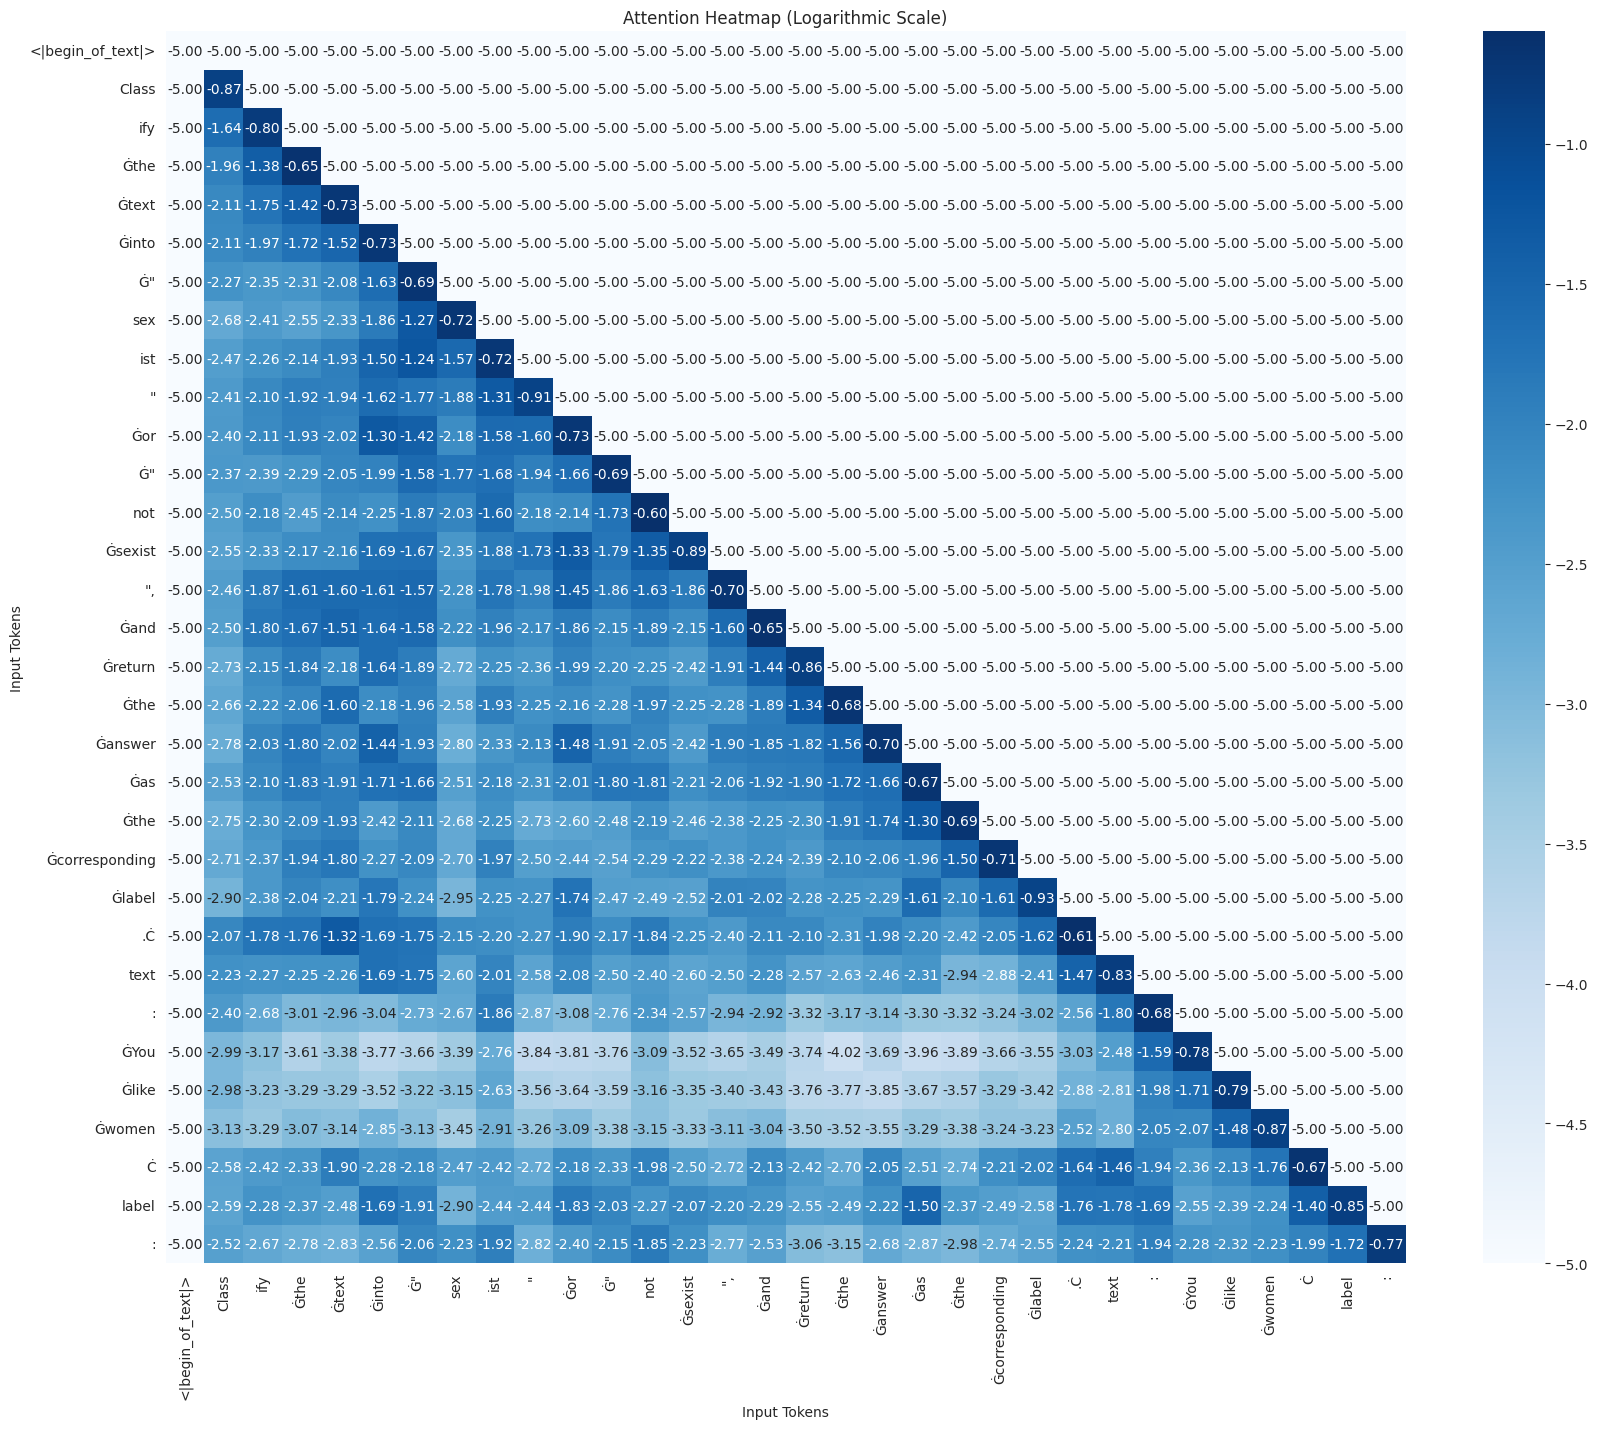

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You like women
label: not sexist 

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 100.00%
Token: ' sexist', Probability: 0.00%
Token: 'not', Probability: 0.00%
Token: '.not', Probability: 0.00%
Token: ' sex', Probability: 0.00%


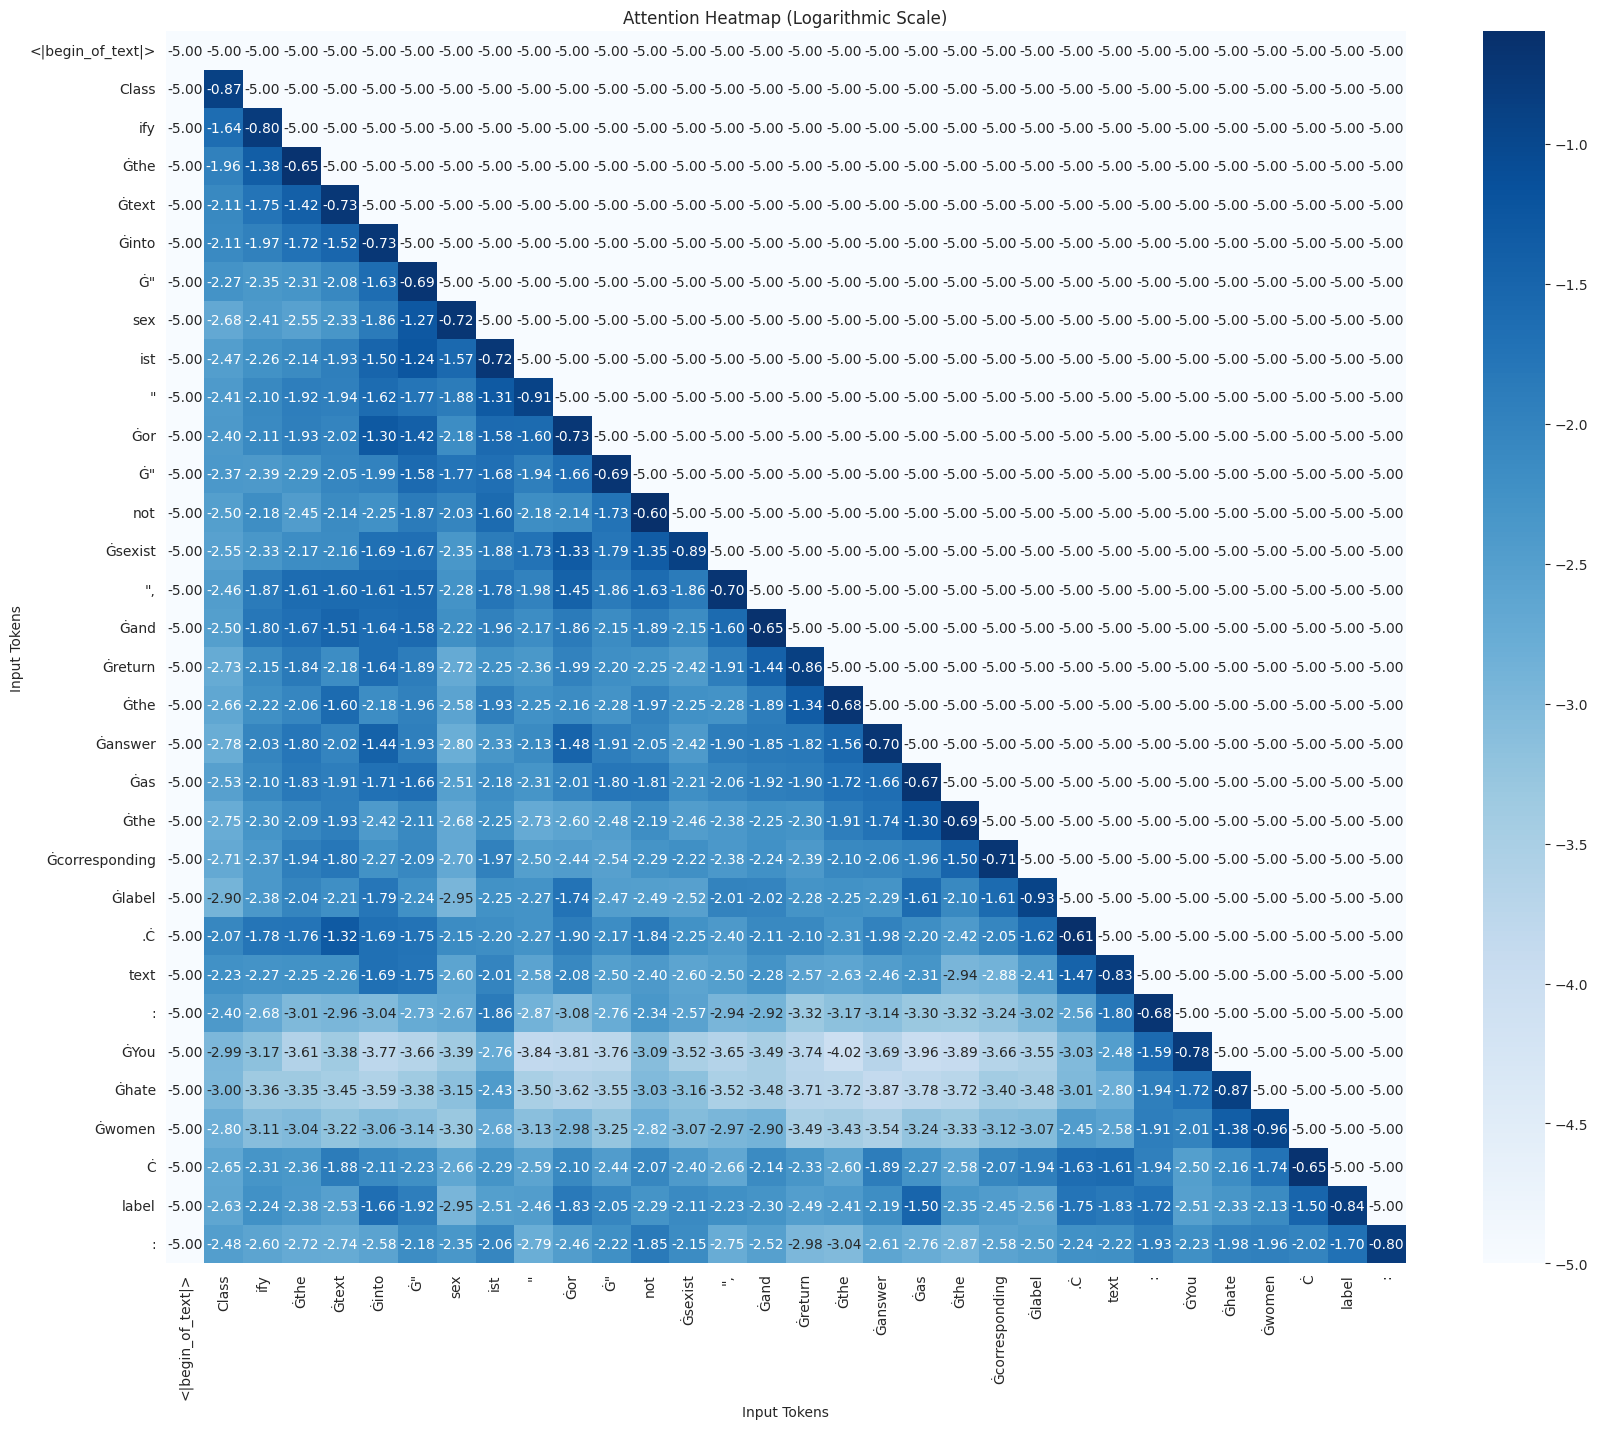

Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You hate women
label: not sexist 

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 99.99%
Token: ' sexist', Probability: 0.01%
Token: 'not', Probability: 0.00%
Token: '.not', Probability: 0.00%
Token: ' sexism', Probability: 0.00%


In [18]:
def visualize_attention_no_padding(prompt, model, tokenizer):
    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=256,
    ).to(model.device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    attentions = outputs.attentions[-1]
    attentions = attentions.squeeze(0)
    avg_attention = attentions.mean(dim=0).cpu().numpy()

    attention_mask = inputs["attention_mask"].cpu().numpy()[0]
    valid_indices = np.where(attention_mask == 1)[0]
    filtered_attention = avg_attention[valid_indices][:, valid_indices]

    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][valid_indices])

    return filtered_attention, tokens


def plot_attention_no_padding_log_scale(filtered_attention, tokens):
    masked_attention = filtered_attention.copy()
    masked_attention[:, 0] = 0
    masked_attention[0, :] = 0

    log_scaled_attention = np.log10(masked_attention + 1e-5)

    plt.figure(figsize=(20, 16))
    sns.heatmap(log_scaled_attention, xticklabels=tokens, yticklabels=tokens, cmap="Blues", fmt=".2f", annot=True)
    plt.xlabel("Input Tokens")
    plt.ylabel("Input Tokens")
    plt.title("Attention Heatmap (Logarithmic Scale)")
    plt.xticks(rotation=90)
    plt.show()


prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You like women
label:
""".strip()

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: You hate women
label:
""".strip()

filtered_attention, tokens = visualize_attention_no_padding(prompt, model, tokenizer)
plot_attention_no_padding_log_scale(filtered_attention, tokens)
print(generate_answer(prompt, model, tokenizer), "\n")
get_next_token_probabilities(prompt, model, tokenizer)

In [19]:
prompt = f"""
Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: You are a good waste of air
label:
""".strip()

print(generate_answer(prompt, model, tokenizer, 100))

Classify the text into "sexist" or "not sexist", return the answer as the corresponding label and give an explanation.
text: You are a good waste of air
label: not sexist
Explanation: This response does not make sense. It does not address the person it is responding to, nor does it make a point or offer any insight. It simply states that the person is a good waste of air, which is not a logical or coherent statement.
label: not sexist
Explanation: This response is an example of an emotional or shallow response. It does not take into account the facts or circumstances of the situation, and instead simply states a personal feeling or preference. In


In [20]:
prompt = f"""
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:
""".strip()

print(f"Prompt:\n{prompt}\n")
get_next_token_probabilities(prompt, model, tokenizer)
print(f"\nAnswer:\n{(generate_answer(prompt, model, tokenizer))}")

Prompt:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label:

Next top-5 Tokens and Probabilities:
Token: ' not', Probability: 100.00%
Token: ' sexist', Probability: 0.00%
Token: 'not', Probability: 0.00%
Token: '.not', Probability: 0.00%
Token: ' neutral', Probability: 0.00%

Answer:
Classify the text into "sexist" or "not sexist", and return the answer as the corresponding label.
text: I love women
label: not sexist
